In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import copy
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torchvision.models as models
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset
from torcheval.metrics.functional import multiclass_confusion_matrix

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from joblib import parallel_backend
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, model_selection
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.metrics import classification_report
import pickle



#### load train and validation csv files

In [2]:
train_df = pd.read_csv('small_train_csv')
val_df = pd.read_csv('val_data_csv')
print(len(val_df), len(train_df))

4896 21064


#### create custom dataset with torch class Dataset

In [3]:

labels_dict = {"crack_alligator_area": 0, "crack_longitudinal": 1, "crack_reflection": 2, 
               "crack_transversal": 3, "patches": 4, "pothole": 5, "raveling": 6}
inv_labels_dict = {v: k for k, v in labels_dict.items()}

class CustomDataset(Dataset):
    def __init__(self, root_dir: str, labels: pd.Series, names: pd.Series, transform=None):
        super().__init__()
        self.data = []
        self.transform = transform
        self.root_dir = root_dir
        img_files = [(label, os.path.join(root_dir, name)) for 
                     name, label in zip(names, labels)]
        self.data.extend(img_files)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][1]
        label = self.data[index][0]
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"] 
            
        return image, labels_dict[label]



#### create transforms for different augmentations of data

In [4]:
data_transforms = {
    'r_class': A.Compose([
    A.Rotate(always_apply=True, limit=(-90, 90)),
    A.ColorJitter(always_apply=True, brightness=(0.8, 1.5), 
                  contrast=(0.8, 2), saturation=(0.8, 1.5), hue=(-0.2, 0.2)),    
    A.Perspective(always_apply=True, scale=(0.05, 0.5), keep_size=0),
    A.Emboss(always_apply=True, alpha=(0.2, 0.4), strength=(0.2, 5.0)),
    A.GridDistortion(always_apply=True, num_steps=7),
    A.Resize(p=1.0, height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()    
        ]),
    'train': A.Compose([    
    A.HorizontalFlip(p=0.5),
    A.CLAHE(clip_limit=(1, 20)),
    A.AdvancedBlur(always_apply=False, p=0.5, blur_limit=(3, 29)),
    A.ToGray(always_apply=False, p=0.5),
    A.GridDistortion(always_apply=False, p = 0.5, num_steps=5),
    A.Perspective(always_apply=False, p = 0.5, scale=(0.05, 0.5), keep_size=0),
    A.RandomBrightnessContrast(p=0.5),
    A.Resize(p=1.0, height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
        ]),
    'val': A.Compose([
        A.Resize(p=1.0, height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ])
}

#### determine rare classes and create description dataframe with these classes

In [ ]:
rare_classes = ["crack_alligator_area", "crack_reflection", "pothole", "raveling"]
df_rare_classes = train_df[train_df.class_label.isin(rare_classes)]
df_rare_classes.info()

#### create datasets for train, validation and rare classes dataset, that we used to increase image number for rare classes of distress

In [6]:
# create datasets from small crops
r_class_dataset_small = CustomDataset(root_dir ='crops/small', labels = df_rare_classes['class_label'], names = df_rare_classes['file_name'],
                             transform = data_transforms['r_class'])
train_dataset_small = CustomDataset(root_dir ='crops/small', labels = train_df['class_label'], names = train_df['file_name'],
                             transform = data_transforms['train'])
train_dataset_small_balanced = torch.utils.data.ConcatDataset([train_dataset_small, r_class_dataset_small])
val_dataset_small = CustomDataset(root_dir ='crops/small', labels = val_df['class_label'], names = val_df['file_name'],
                             transform = data_transforms['val'])
print(len(val_dataset_small), len(train_dataset_small_balanced))

4896 27015


In [7]:
# Cuda maintenance
import gc
gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch device: ", device)


Torch device:  cpu


#### load extract_features function that use RADAM algorithm to extract features of images

In [8]:
from feature_extraction import extract_features

#### Determine hyperparameters: model backbone, image size (input_dimm), batch size, and parameters for extract_features function (see RADAM documentation)

In [9]:
output_path = 'path_to_results/RADAM_result',
model =   'convnext_nano' #'resnet50', 'resnet34'
depth = 'all'
pooling = 'RAEspatial'
input_dimm = 224
batch_size = 20
multigpu = False
seed = 666999
M = 4
iterations = 1

#### get features for train and test datasets

In [11]:
X_train, Y_train = extract_features(model, train_dataset_small_balanced, depth=depth, pooling=pooling, M=M,
                                                      batch_size=batch_size, multigpu=multigpu, seed=seed)

extracting 3904 features for 27015 images...


In [12]:
X_test, Y_test = extract_features(model, val_dataset_small, depth=depth, pooling=pooling, M=M,
                                                      batch_size=batch_size, multigpu=multigpu, seed=seed)

extracting 3904 features for 4896 images...


#### construct classification module to classify images on the basis of extracted features

In [15]:
file1 = 'path_to_results' + model + pooling + str(M) + '_EVALUATION.pkl'

In [10]:
gtruth_= []
preds_KNN, preds_LDA, preds_SVM = [], [], []
accs_KNN, accs_LDA, accs_SVM = [], [], []

In [17]:
gtruth_.append(Y_test)
with parallel_backend('threading', n_jobs=16):
                    
    KNN = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', 
                                                leaf_size=30, p=2, metric='minkowski', metric_params=None)
                    
                    
    KNN.fit(X_train,Y_train)
    preds=KNN.predict(X_test)
                
    preds_KNN.append(preds)            
    acc= sklearn.metrics.accuracy_score(Y_test, preds)        
    accs_KNN.append(acc*100)     
                    
                    
    LDA= LinearDiscriminantAnalysis(solver='lsqr', 
                                        shrinkage='auto', priors=None,
                                        n_components=None, 
                                        store_covariance=False, 
                                        tol=0.0001, covariance_estimator=None)                     
                    
                    
    LDA.fit(X_train,Y_train)
    preds=LDA.predict(X_test)
              
    preds_LDA.append(preds)            
    acc= sklearn.metrics.accuracy_score(Y_test, preds)
    accs_LDA.append(acc*100)  
                    
              
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='scale', 
                    coef0=0.0, shrinking=True, probability=False, tol=0.001,
                    cache_size=200, class_weight=None, verbose=False, 
                    max_iter=100000, decision_function_shape='ovr', 
                    break_ties=False, random_state=seed)
                    
                
                 
    SVM.fit(X_train,Y_train)
                    
    preds=SVM.predict(X_test)
               
    preds_SVM.append(preds)            
    acc= sklearn.metrics.accuracy_score(Y_test, preds)
    accs_SVM.append(acc*100)       

    if os.path.isfile(file1):           
        with open(file1, 'rb') as f:
            results = pickle.load(f) 
            
    else:
        results = {'gtruth_':gtruth_,
                    'preds_KNN':preds_KNN,
                    'accs_KNN':accs_KNN,
                    'preds_LDA':preds_LDA,
                    'accs_LDA':accs_LDA,
                    'preds_SVM':preds_SVM,
                    'accs_SVM':accs_SVM,
        }  
         
        with open(file1, 'wb') as f:
            pickle.dump(results, f)

In [42]:
print('Acc: KNN:', f'{np.round(accs_KNN[0], 1)}', ' || LDA:', f'{np.round(accs_LDA[0], 1)}', ' || SVM:', f'{np.round(accs_SVM[0], 1)}',  sep=' ', end='', flush=True)

Acc: KNN: 57.7  || LDA: 72.8  || SVM: 76.4

In [23]:
# SVM for unbalanced dataset - change parameter class_weight to 'balanced'
preds_SVM = []
gtruth_.append(Y_test)
with parallel_backend('threading', n_jobs=16):
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='scale', 
                    coef0=0.0, shrinking=True, probability=True, tol=0.001,
                    cache_size=200, class_weight='balanced', verbose=False, 
                    max_iter=100000, decision_function_shape='ovr', 
                    break_ties=False, random_state=seed)
               
    SVM.fit(X_train,Y_train)                            
    preds=SVM.predict(X_test)               
    preds_SVM.append(preds)            
    acc= sklearn.metrics.accuracy_score(Y_test, preds)
    accs_SVM.append(acc*100)
target = torch.LongTensor(Y_test)
input = torch.LongTensor(preds_SVM[0])
SVM_matrix = multiclass_confusion_matrix(input, target, 7)   

#### create classification report

In [25]:
label_names = ["crack_alligator_area", "crack_longitudinal", "crack_reflection", 
               "crack_transversal", "patches", "pothole", "raveling"]
target = torch.LongTensor(Y_test)
input = torch.LongTensor(preds_SVM[0])

print(classification_report(target, input,target_names=label_names))

                      precision    recall  f1-score   support

crack_alligator_area       0.18      0.65      0.28        40
  crack_longitudinal       0.85      0.77      0.81      1854
    crack_reflection       0.71      0.63      0.67       214
   crack_transversal       0.89      0.75      0.81      1736
             patches       0.63      0.80      0.71       941
             pothole       0.18      0.45      0.26        53
            raveling       0.14      0.21      0.17        58

            accuracy                           0.75      4896
           macro avg       0.51      0.61      0.53      4896
        weighted avg       0.79      0.75      0.77      4896



#### construct confusion matrix for different classification algorithms

In [19]:
target = torch.LongTensor(Y_test)
input = torch.LongTensor(preds_KNN[0])
KNN_matrix = multiclass_confusion_matrix(input, target, 7)
input = torch.LongTensor(preds_SVM[0])
SVM_matrix = multiclass_confusion_matrix(input, target, 7)
input = torch.LongTensor(preds_LDA[0])
LDA_matrix = multiclass_confusion_matrix(input, target, 7)

In [26]:
df = pd.DataFrame(SVM_matrix)

#### get image of the confusion matrix

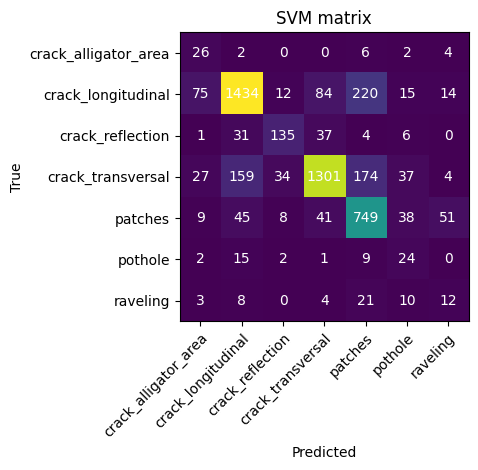

In [27]:
## Get Class Labels
labels = ["crack_alligator_area", "crack_longitudinal", "crack_reflection", 
               "crack_transversal", "patches", "pothole", "raveling"]
class_names = labels

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(df)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels)), labels=labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, SVM_matrix.numpy()[i, j],
                       ha="center", va="center", color="w")

ax.set_title("SVM matrix")
ax.set_ylabel('True', fontsize=10)
ax.set_xlabel('Predicted', fontsize=10)
fig.tight_layout()
plt.savefig('ConMat_SVM.png')
plt.show()
